# EV Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm

In [2]:
# source: https://data.mendeley.com/datasets/5zrtmp7gwd/1

## Data Exploration

In [4]:
sessionsEV = pd.read_csv('Data/EV_CA_US/SYNTHETIC_EV_DATA.csv')

In [ ]:
sessionsEV.loc[:, 'arrivalHour'] = sessionsEV['connectionTime_decimal']
sessionsEV.loc[:, 'durationInHours'] = sessionsEV['chargingDuration']
sessionsEV.loc[:, 'durationInHours'] = sessionsEV['durationInHours'].round(1)
durationMax = 12.0
durationMin = 0.5
sessionsEV = sessionsEV[(sessionsEV['durationInHours'] <= durationMax) & (sessionsEV['durationInHours'] >= durationMin)]

In [8]:
sessionsEV = sessionsEV[['dayIndicator', 'arrivalHour', 'durationInHours', 'kWhDelivered']]
sessionsEV.reset_index(drop=True, inplace=True)

In [5]:
sessionsEV['dayIndicator'].max()/365
sessionsEV['yearIndicator'] = (sessionsEV['dayIndicator'] - 1) // 365 + 1

In [17]:
sessionsEV.head(5).round(2)
print(f"There are {str(sessionsEV.loc[:, 'yearIndicator'].max())} years of data")

There are 82 years of data


In [11]:
print(f"The dataset has been limited to a charging duration Max={durationMax}h and Min={durationMin}h")

The dataset has been limited to a charging duration Max=12.0h and Min=0.5h


In [12]:
def print_3_histograms(df):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        df.loc[:, 'arrivalHour'].hist(ax=axes[0], bins=20, alpha=0.5)
        axes[0].axvline(df['arrivalHour'].median(), color='red', linestyle='dashed', linewidth=1)
        axes[0].set_title('arrivalHour')
        df.loc[:, 'durationInHours'].hist(ax=axes[1], bins=20, alpha=0.5)
        axes[1].axvline(df['durationInHours'].median(), color='red', linestyle='dashed', linewidth=1)
        axes[1].set_title('durationInHours')
        df.loc[:, 'kWhDelivered'].hist(ax=axes[2], bins=20, alpha=0.5)
        axes[2].axvline(df['kWhDelivered'].median(), color='red', linestyle='dashed', linewidth=1)
        axes[2].set_title('kWhDelivered')

        plt.tight_layout()

def print_3_scatters(df):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        df.plot(x='durationInHours', y='kWhDelivered', kind='scatter', alpha=0.1, ax=axes[0])
        axes[0].set_title('kWh vs Duration')
        df.plot(x='arrivalHour', y='durationInHours', kind='scatter', alpha=0.1, ax=axes[1])
        axes[1].set_title('Duration vs ArrivalHour')
        df.plot(x='arrivalHour', y='kWhDelivered', kind='scatter', alpha=0.1, ax=axes[2])
        axes[2].set_title('kWh vs ArrivalHour')

        plt.tight_layout()

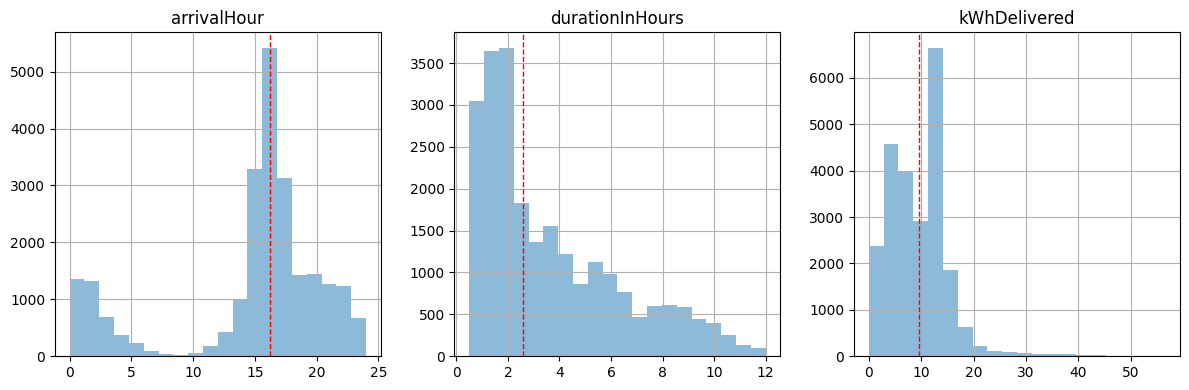

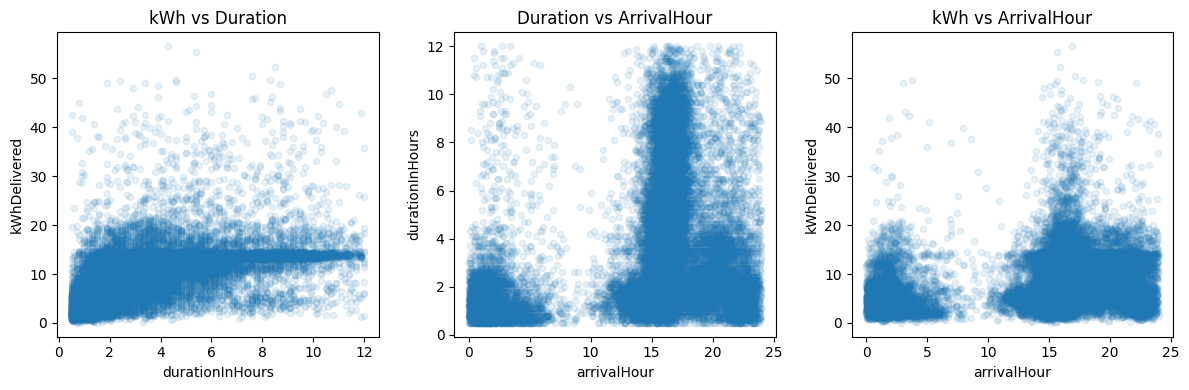

In [13]:
for y in np.random.randint(0, 80, 1): # random year selection
    print_3_histograms(df=sessionsEV[sessionsEV['yearIndicator'] == y])
    print_3_scatters(df=sessionsEV[sessionsEV['yearIndicator'] == y])

All years are similar. Define a dummy starting date to create the datetime

## Preprocessing

### Scaling and resampling?

Data should be modified to charging stations with higher power demands? (van and heavy-duty vehicles)
- Duration of charging <= 5h?
- Energy delivered per session shifted?

In [11]:
sessionsEVmax5H = sessionsEV[(sessionsEV['durationInHours'] < 5) & (sessionsEV['yearIndicator'] == 1)].copy()
sessionsEVrest = sessionsEV[(sessionsEV['durationInHours'] >= 5) & (sessionsEV['yearIndicator'] == 1)].copy()

In [12]:
sessionsEVmax5H.groupby('dayIndicator')[['durationInHours', 'kWhDelivered']].agg(['count', 'mean', 'min', 'max']).describe().round(1)

durationInHours                      kWhDelivered                     
                count   mean    min    max        count   mean    min    max
count           365.0  365.0  365.0  365.0        365.0  365.0  365.0  365.0
mean             44.3    2.2    0.6    4.7         44.3    8.1    1.3   22.9
std              18.2    0.2    0.1    0.3         18.2    0.9    0.6    8.3
min               8.0    1.5    0.5    2.7          8.0    3.8    0.1    6.6
25%              29.0    2.1    0.5    4.6         29.0    7.6    0.9   17.4
50%              47.0    2.2    0.5    4.8         47.0    8.1    1.2   20.2
75%              59.0    2.3    0.6    4.9         59.0    8.7    1.6   26.5
max              82.0    2.9    1.1    4.9         82.0   11.1    3.7   54.4

In [13]:
sessionsEVrest.groupby('dayIndicator')[['durationInHours', 'kWhDelivered']].agg(['count', 'mean', 'min', 'max']).describe().round(1)

durationInHours                      kWhDelivered                     
                count   mean    min    max        count   mean    min    max
count           365.0  365.0  365.0  365.0        365.0  365.0  365.0  365.0
mean             17.5    7.5    5.2   10.7         17.5   13.5    5.8   24.8
std               6.8    0.5    0.3    1.0          6.8    1.4    3.3    9.2
min               2.0    5.8    5.0    6.5          2.0    7.6    0.5   11.7
25%              13.0    7.1    5.0   10.1         13.0   12.7    3.3   17.6
50%              18.0    7.5    5.1   10.8         18.0   13.4    5.0   22.1
75%              23.0    7.8    5.3   11.4         23.0   14.2    7.9   31.2
max              31.0    8.9    7.7   12.0         31.0   19.2   13.8   53.8

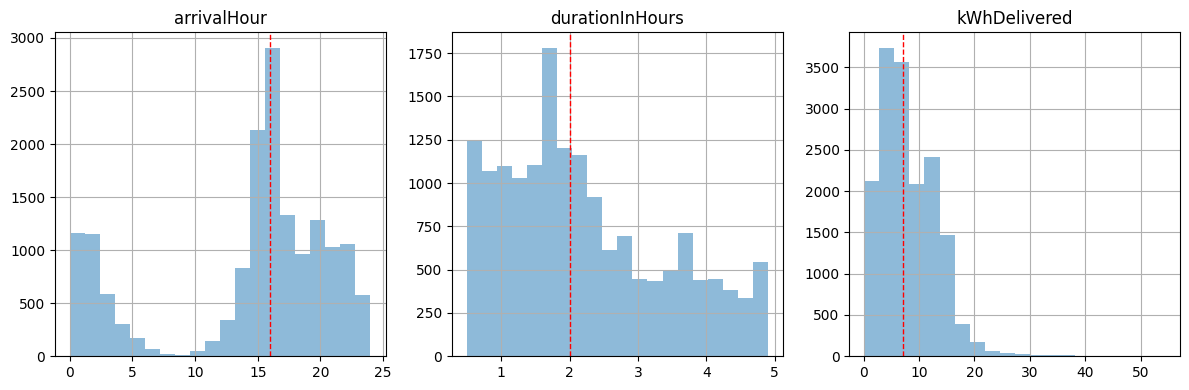

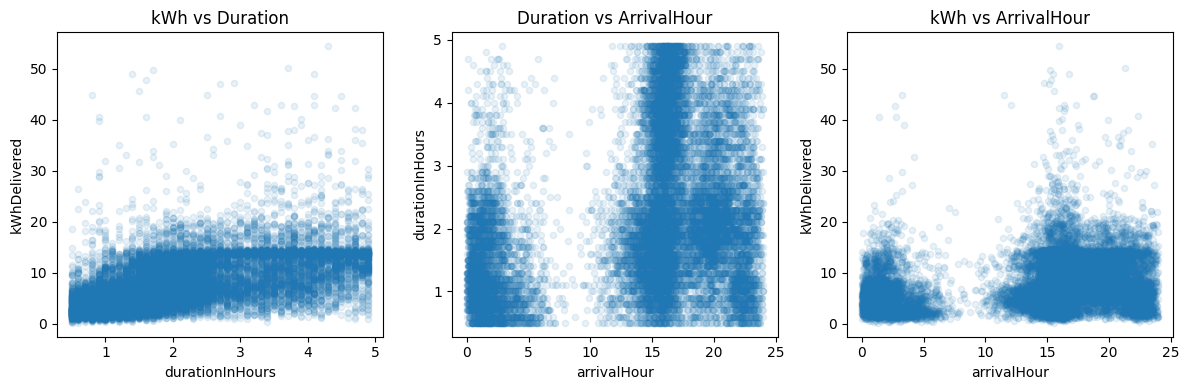

In [14]:
print_3_histograms(df=sessionsEVmax5H)
print_3_scatters(df=sessionsEVmax5H)

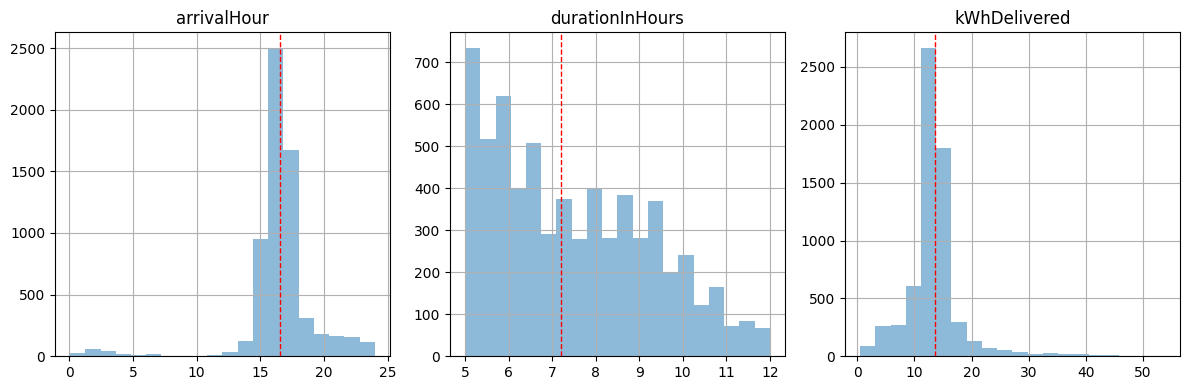

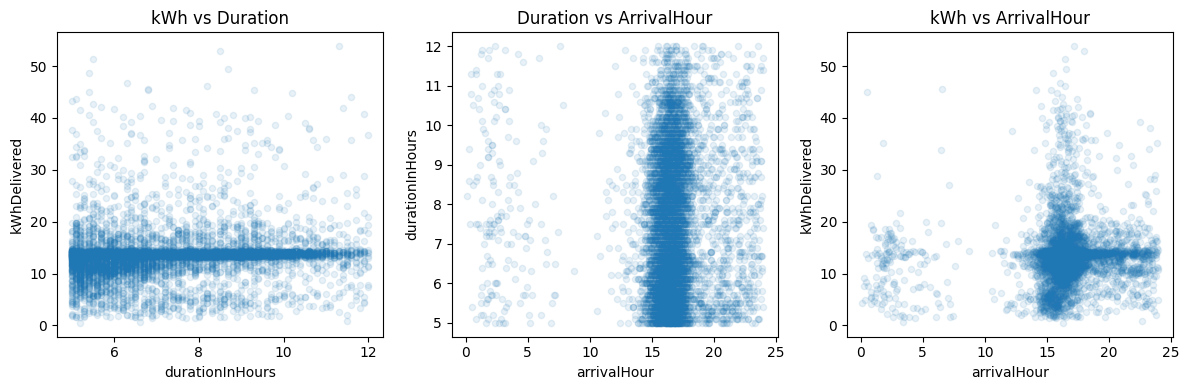

In [15]:
print_3_histograms(df=sessionsEVrest)
print_3_scatters(df=sessionsEVrest)

### Power Aggregation


In [16]:
dateStart = '2021-7-1' #'2020-1-1' #'2019-7-1' #'2019-1-1'
# daysToAggregate = np.round(3/12 * 365)
daysToAggregate = 0.5 * 365

In [17]:
daysToAggregate

182.5

In [18]:
sessionsEV.loc[:, 'beginDateTime'] = pd.to_datetime(dateStart, utc=False).tz_localize('America/Los_Angeles')
sessionsEV.loc[:, 'beginDateTime'] = sessionsEV['beginDateTime'] + pd.to_timedelta(sessionsEV['dayIndicator'] - 1, unit='days') + pd.to_timedelta(sessionsEV['arrivalHour'], unit='h')

In [19]:
sessionsEV = sessionsEV[['beginDateTime', 'durationInHours', 'kWhDelivered']]
sessionsEV.sort_values(by='beginDateTime', inplace=True)
sessionsEV.reset_index(drop=True, inplace=True)

In [20]:
sessionsEV.head(3)

beginDateTime  durationInHours  kWhDelivered
0 2021-07-01 00:15:06.436874937-07:00              1.2      5.253114
1 2021-07-01 01:22:29.781324382-07:00              1.0      7.327850
2 2021-07-01 12:29:08.253034339-07:00              0.9      5.417818

In [21]:
def aggregate_EVs(sessionsToAgg, dateStart, daysAgg, resAgg):
    dtAggregationRef = pd.to_datetime(dateStart, utc=False).tz_localize('America/Los_Angeles')
    resInHours = resAgg / 60
    eqMaxIndexSize = np.int64((daysAgg * 24 + 24) / resInHours)

    print(f'Aggregating {daysAgg} days with {resInHours}H resolution. Resulting size of session array: {eqMaxIndexSize}')

    sessionsToAgg.sort_values(by='beginDateTime', inplace=True)
    sessionsToAgg.reset_index(drop=True, inplace=True)

    sessions = sessionsToAgg[(
        sessionsToAgg['beginDateTime'] >= dtAggregationRef) & 
        (sessionsToAgg['beginDateTime'] <= dtAggregationRef + pd.Timedelta(days=daysAgg))].copy()
    
    sessions.loc[:, 'durationInHours'] = (sessions['durationInHours'] / resInHours).round() * resInHours
    sessions.loc[sessions['durationInHours'] == 0.0, 'durationInHours'] = resInHours
    sessions.loc[:, 'hourRefConnect'] = (sessions['beginDateTime'] - dtAggregationRef).dt.total_seconds() / 3600
    sessions.loc[:, 'indexRefConnect'] =  np.int64((sessions['hourRefConnect'] / resInHours).round())
    # sessions.loc[:, 'hourRefConnect'] = (sessions['hourRefConnect'] / resInHours).round() * resInHours
    # sessions.loc[:, 'indexRefConnect'] = np.int64(sessions['hourRefConnect'] / resInHours)
    sessions.sort_values(by='beginDateTime', inplace=True)

    sessions.reset_index(drop=True, inplace=True)
    EqBin = np.zeros([len(sessions), eqMaxIndexSize])

    for session_i in range(len(sessions)):
        sessionArray = np.zeros(EqBin.shape[1])
        start_idx = sessions.loc[session_i, 'indexRefConnect']
        end_idx = sessions.loc[session_i, 'indexRefConnect'] + np.int64(sessions.loc[session_i, 'durationInHours'] / resInHours)
        sessionArray[start_idx:end_idx] = sessions.loc[session_i, 'kWhDelivered']
        # EqBin[session_i, :] = sessionArray / (sessions.loc[session_i, 'durationInHours'] / resInHours) # energy
        EqBin[session_i, :] = sessionArray / sessions.loc[session_i, 'durationInHours'] # power

    Agg = np.sum(EqBin, axis=0)
    newDatetime = pd.Series([dtAggregationRef + pd.Timedelta(hours=i * resInHours) for i in range(Agg.shape[0])])
    AggDated = pd.DataFrame({'datetime': newDatetime, 
                             'TotPowerEqBin': Agg})

    return Agg, AggDated, EqBin
    

In [22]:
AggQH, AggQHdt, EqBinQH = aggregate_EVs(sessionsToAgg=sessionsEV[['beginDateTime', 'durationInHours', 'kWhDelivered']],
                                              dateStart=dateStart,
                                              daysAgg=daysToAggregate,
                                              resAgg=15)

AggH, AggHdt, EqBinH = aggregate_EVs(sessionsToAgg=sessionsEV[['beginDateTime', 'durationInHours', 'kWhDelivered']],
                                           dateStart=dateStart,
                                           daysAgg=daysToAggregate,
                                           resAgg=60)

del EqBinH

Aggregating 182.5 days with 0.25H resolution. Resulting size of session array: 17616
Aggregating 182.5 days with 1.0H resolution. Resulting size of session array: 4404


In [23]:
def print_ts_agg(df, resInHours, weekIdStart, lengthInWeeks, nChargers=None):
        figsize = (30, 5)
        beginWeekDeltaPlot = weekIdStart
        endWeekDeltaPlot = beginWeekDeltaPlot + lengthInWeeks

        if nChargers is None:
                df.loc[
                (df['datetime'] >= pd.to_datetime(dateStart, utc=False).tz_localize('America/Los_Angeles') + pd.Timedelta(weeks=beginWeekDeltaPlot)) &
                (df['datetime'] < pd.to_datetime(dateStart, utc=False).tz_localize('America/Los_Angeles') + pd.Timedelta(weeks=endWeekDeltaPlot)), : 
                ].plot(x='datetime', y='TotPowerEqBin', figsize=figsize, ylim=(0, 140), title=f'Total Power Consumption Aggregated with {resInHours}H resolution')

        else:
                ax = df.loc[
                (df['datetime'] >= pd.to_datetime(dateStart, utc=False).tz_localize('America/Los_Angeles') + pd.Timedelta(weeks=beginWeekDeltaPlot)) &
                (df['datetime'] < pd.to_datetime(dateStart, utc=False).tz_localize('America/Los_Angeles') + pd.Timedelta(weeks=endWeekDeltaPlot)), : 
                ].plot(x='datetime', y='nSessions', figsize=figsize, ylim=(0, 50), title=f'Number of active sessions')

                ax.axhline(nChargers, color='red', linestyle='--', label='nChargers')
                ax.legend()

        plt.tight_layout()

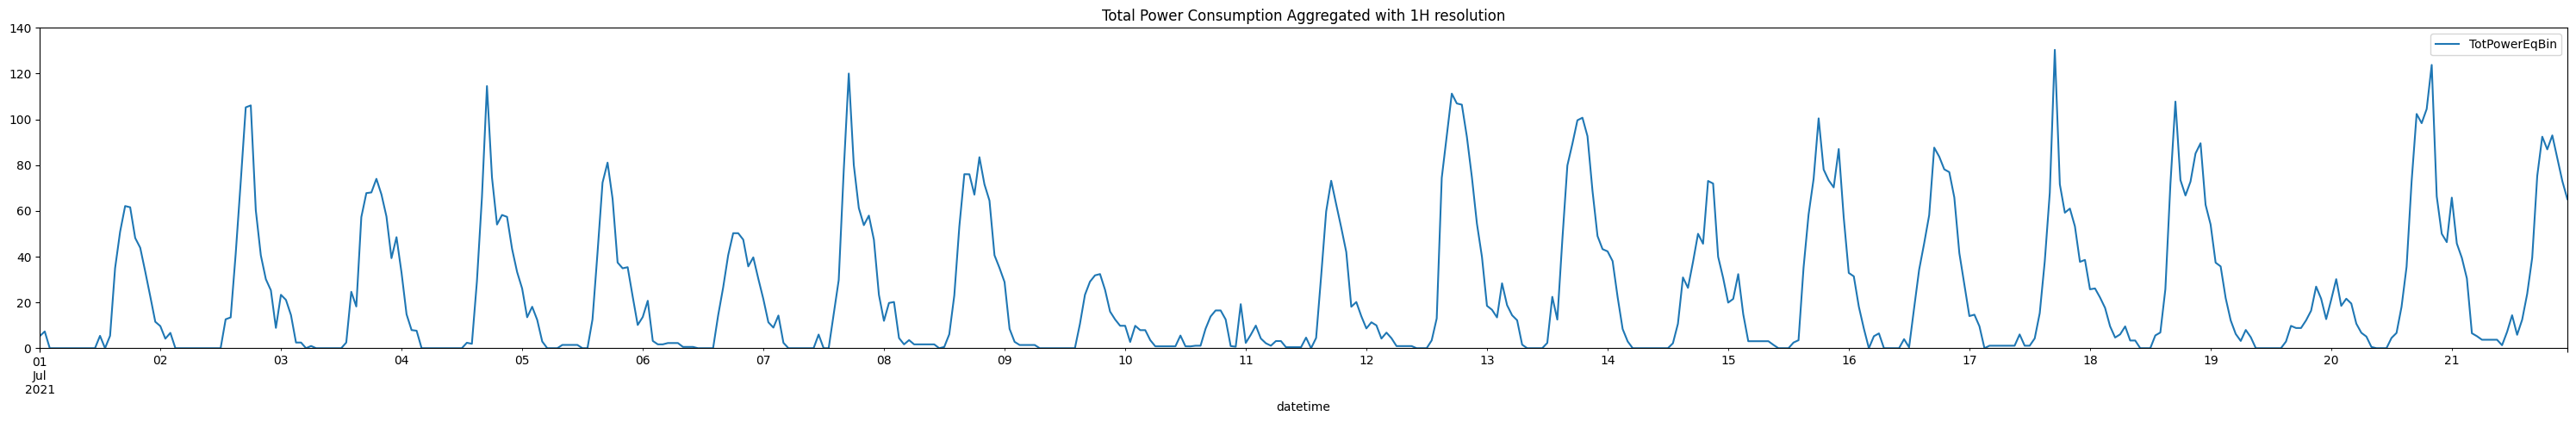

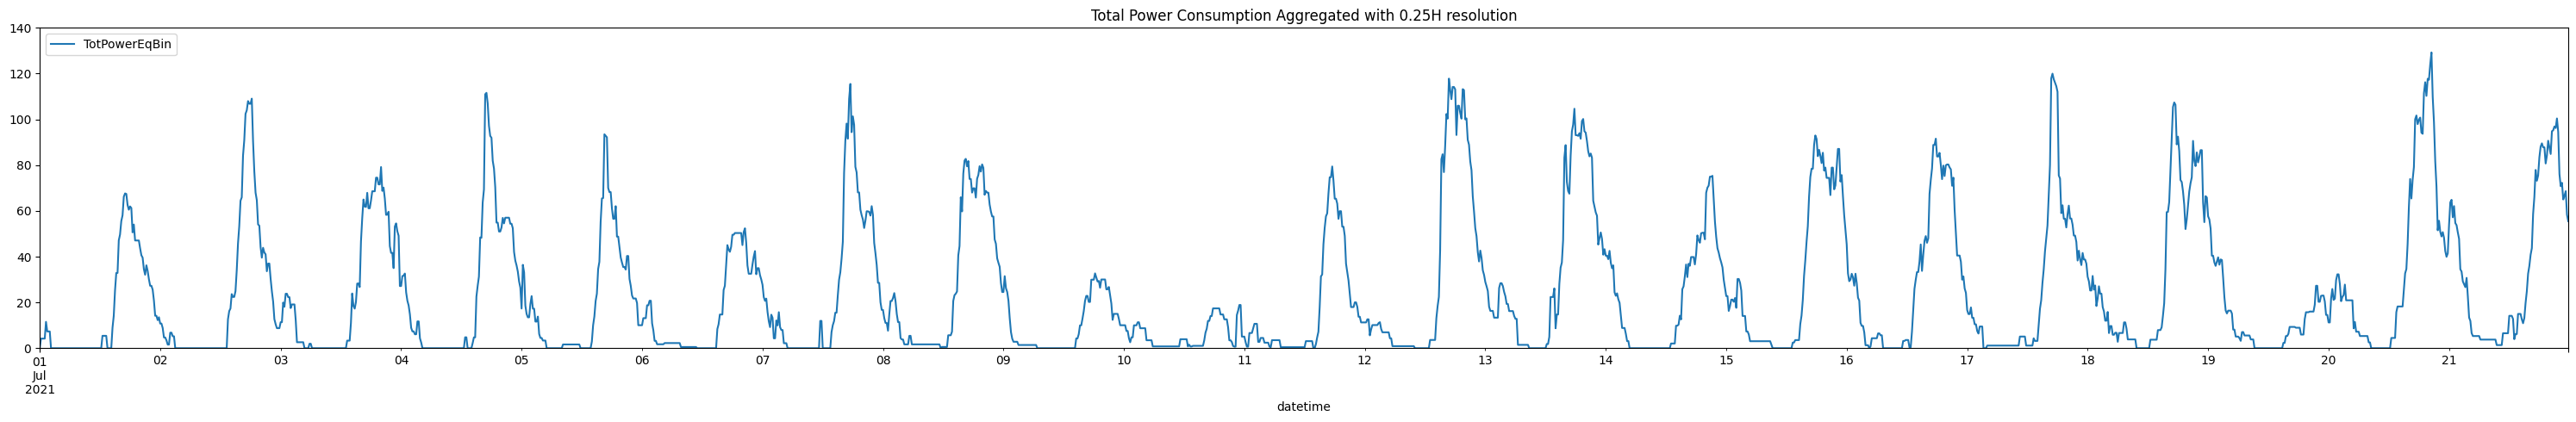

In [24]:
print_ts_agg(df=AggHdt, resInHours=1, weekIdStart=0, lengthInWeeks=3)
print_ts_agg(df=AggQHdt, resInHours=0.25, weekIdStart=0, lengthInWeeks=3)

Keep the aggregated version with 15MIN resolution. The profile seems more realistic and the dissaggregated version would have the same resolution as the time steps of the MPC 

Plotting month 0
Plotting month 1
Plotting month 2


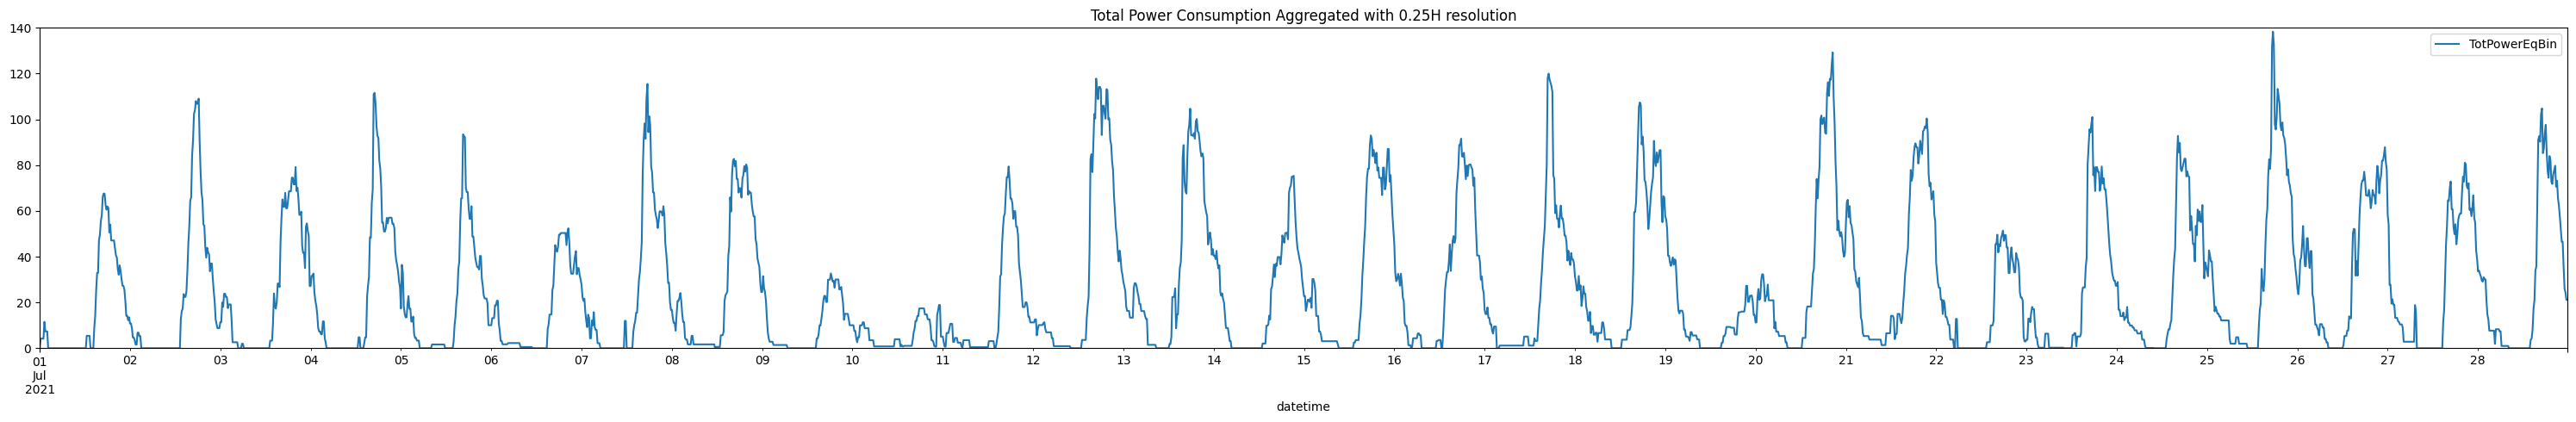

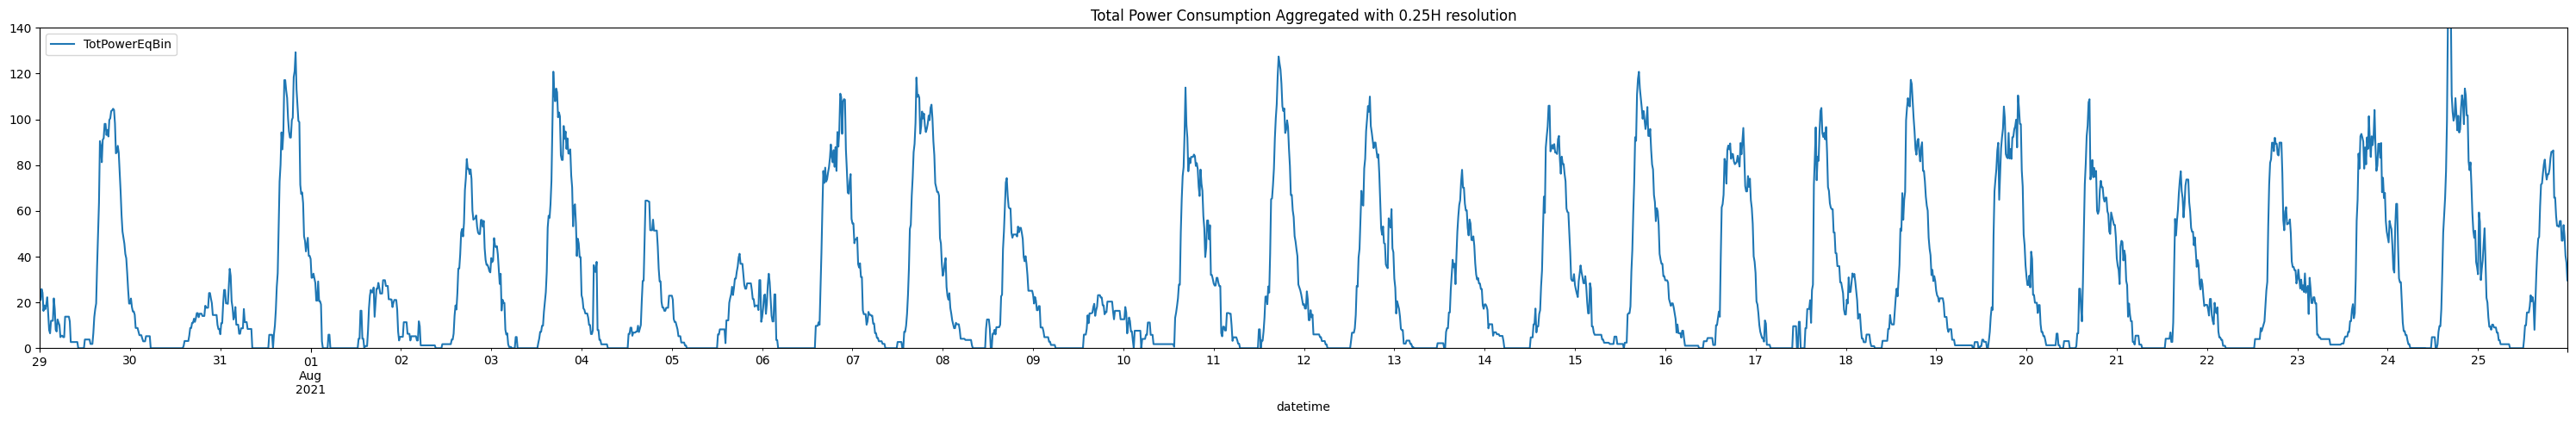

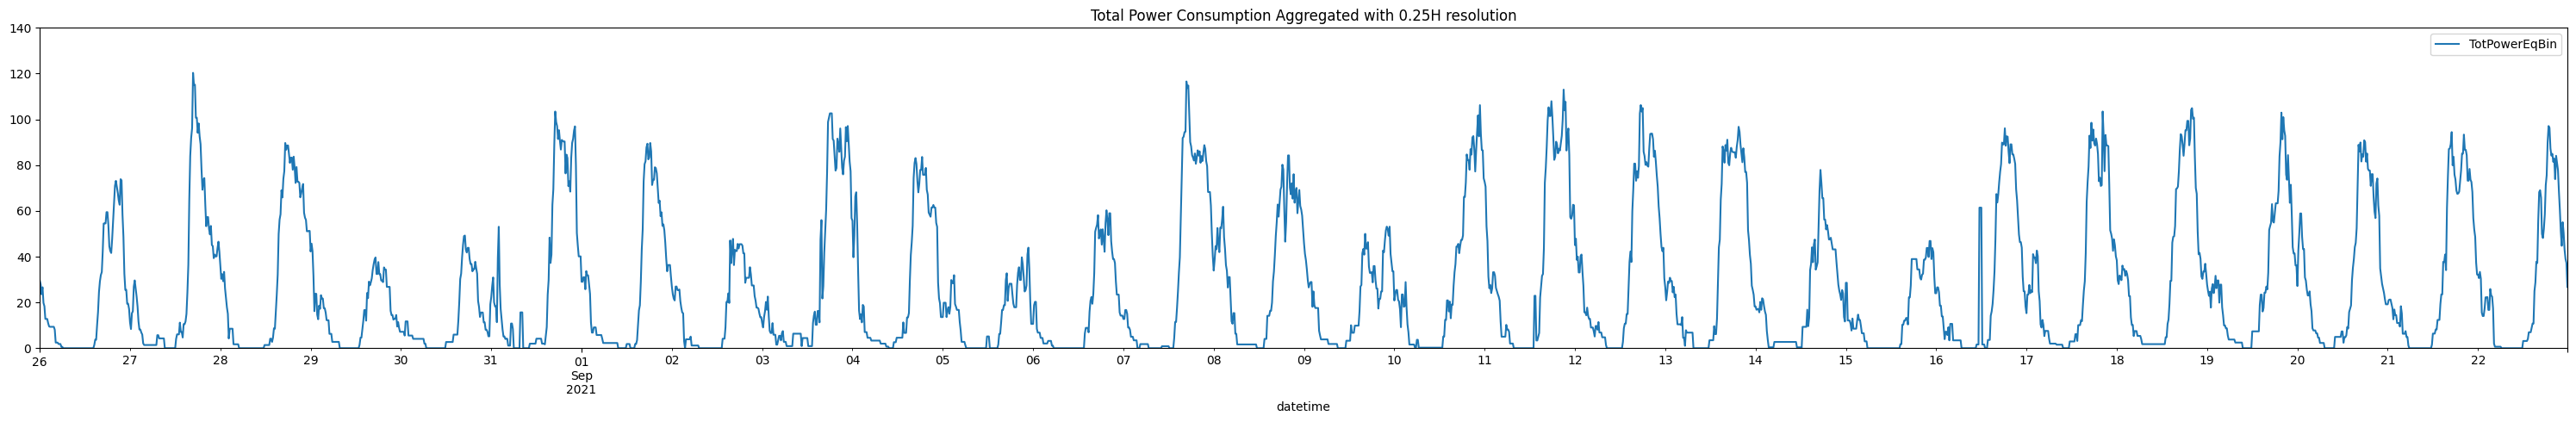

In [25]:
for m in range(3):
    print(f"Plotting month {m}")
    print_ts_agg(df=AggQHdt, resInHours=0.25, weekIdStart=m*4, lengthInWeeks=4)

### Queuing

Based on the nChargers, go over the dataset and simulate fifo queuing: adjusting sessions when there is congestion and registering the delays per session. The delays can be used later to improve the efftiveness of the controller.

In [26]:
nChargers = 30
thresholdnChargers = 10 

(11505, 17616)


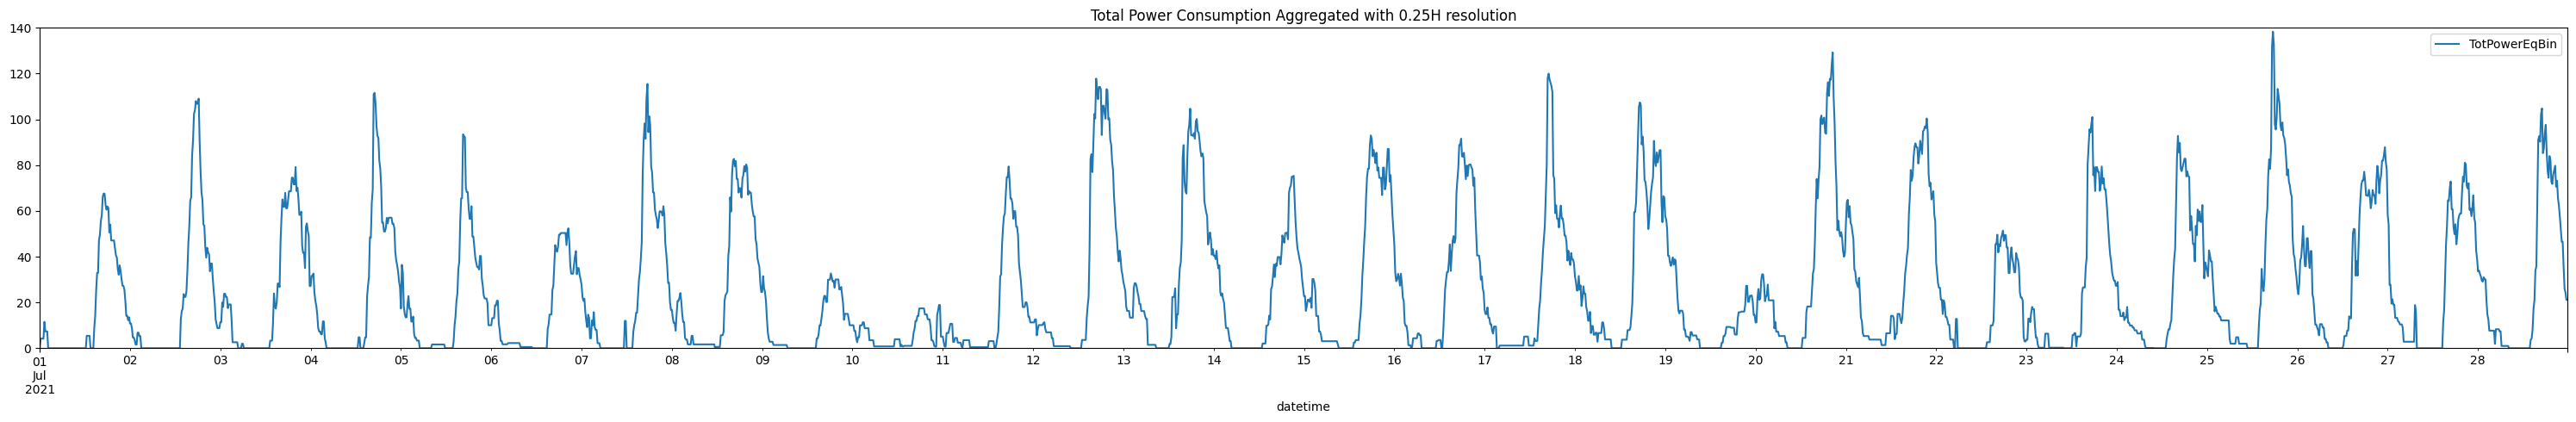

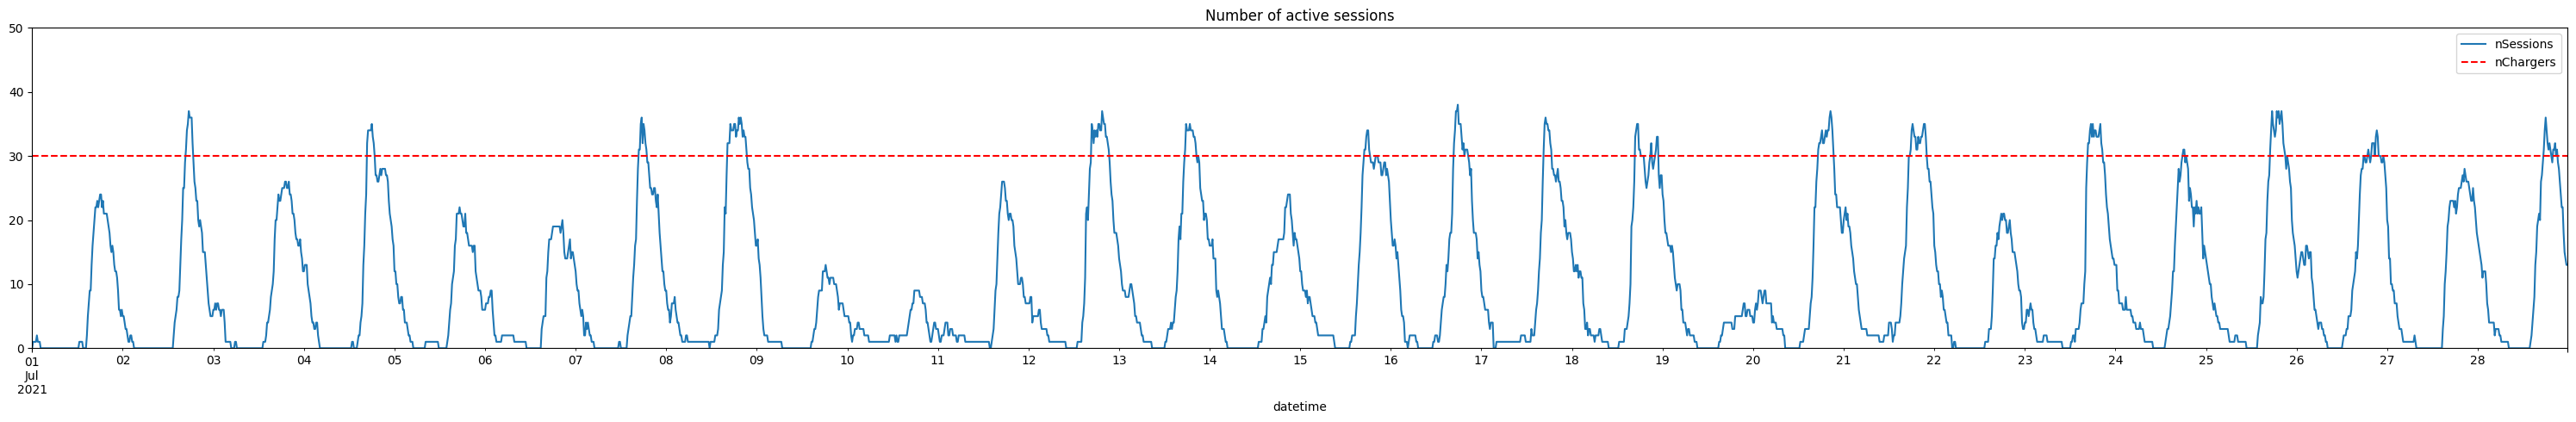

In [27]:
print(EqBinQH.shape)
nSessionsNow = (EqBinQH != 0).sum(axis=0)
nSessionsNowdt = pd.DataFrame({'datetime': AggQHdt['datetime'], 'nSessions': nSessionsNow})
print_ts_agg(df=AggQHdt, resInHours=0.25, weekIdStart=0, lengthInWeeks=4*1)
print_ts_agg(df=nSessionsNowdt, resInHours=0.25, weekIdStart=0, lengthInWeeks=4*1, nChargers=nChargers)

<Axes: xlabel='nSessions', ylabel='TotPowerEqBin'>

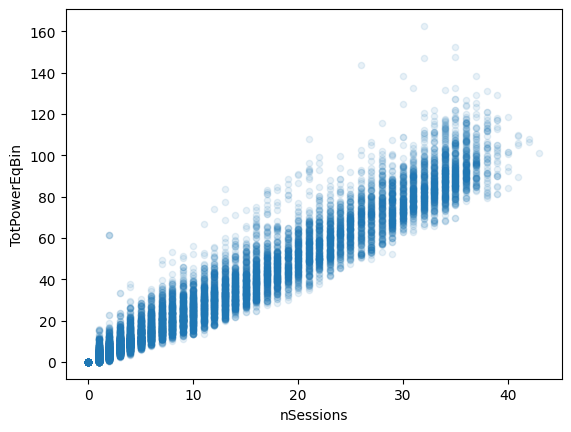

In [28]:
merged = pd.merge(nSessionsNowdt, AggQHdt, on='datetime', how='inner')
# merged = merged.loc[(merged['datetime'] < pd.to_datetime(dateStart, utc=False).tz_localize('America/Los_Angeles') + pd.Timedelta(weeks=52)), :]            
merged.plot(x='nSessions', y='TotPowerEqBin', kind='scatter', alpha=0.1)

# plot per hour
# merged['arrivalHour'] = merged['datetime'].dt.hour
# fig, axes = plt.subplots(4, 6, figsize=(20, 12), sharex=True, sharey=True)
# axes = axes.flatten()

# for hour, grp in merged.groupby('arrivalHour'):
#     if hour < 24:
#         grp.plot(x='nSessions', y='TotPowerEqBin', kind='scatter', alpha=0.1,
#                  ax=axes[hour], label=f'Hour {hour}')
#         axes[hour].set_title(f'Hour {hour}')
#         axes[hour].legend()

# plt.tight_layout()

In [29]:
def sim_queuing(nChargers, nSessionsToQueuedt, sessionsToQueue, resInHours, thresholdnChargers=3, verbose=True):
    delaysSessions = np.zeros([sessionsToQueue.shape[0]])
    delaysAggts = np.zeros([sessionsToQueue.shape[1]])
    idStepsCloseToMax = nSessionsToQueuedt.loc[nSessionsToQueuedt['nSessions'] > nChargers - thresholdnChargers, :].index # threshold ensures queuing is correct

    for idStep in tqdm(idStepsCloseToMax, desc="Simulating queue"):
        nSessions = (sessionsToQueue != 0).sum(axis=0)
        nExtraSessions = nSessions[idStep] - nChargers
        if verbose: print(f"Step {idStep}: {nExtraSessions} extra sessions")

        while nExtraSessions > 0:
            if verbose: print(f"Delaying {nExtraSessions} sessions by one step...")
            idSessionsNew = np.where((sessionsToQueue[:, idStep - 1] == 0) & (sessionsToQueue[:, idStep] != 0))[0]
            currentDelays = delaysSessions[idSessionsNew]
            idMinDelays = np.argsort(currentDelays)[0:nExtraSessions] # delay sessions with minimum delay
            idSessionsDelayed = idSessionsNew[idMinDelays]

            newSessionsAtIdStep = sessionsToQueue[idSessionsDelayed, :] 
            newSessionsDelayed = np.append(np.zeros([nExtraSessions, 1]), newSessionsAtIdStep[:, 0:-1], axis=1)
            sessionsToQueue[idSessionsDelayed, :] = newSessionsDelayed
            delaysSessions[idSessionsDelayed] += 1 # accumulated delays per session
            delaysAggts[idStep] = nExtraSessions # aggregated delays per step

            idStep += 1
            nSessions = (sessionsToQueue != 0).sum(axis=0)
            nExtraSessions = nSessions[idStep] - nChargers

    delaysAggts = delaysAggts * resInHours
    delaysAggdt = pd.DataFrame({'datetime': nSessionsToQueuedt['datetime'], 'delayAgg': delaysAggts})
    return sessionsToQueue, delaysSessions, delaysAggdt

#### Test

In [30]:
dayId = 14
testEqBinQH = EqBinQH[:4000, 96 * dayId : 96 * dayId + 96 * 7].copy()
testNSessionsNowdt = nSessionsNowdt.iloc[96 * dayId : 96 * dayId + 96 * 7, :].copy()
testNSessionsNowdt = testNSessionsNowdt.reset_index(drop=True)
testAggQHdt = AggQHdt.loc[AggQHdt['datetime'].isin(testNSessionsNowdt['datetime']), :].copy()

In [31]:
testNSessionsNowdt.loc[testNSessionsNowdt['nSessions'] > nChargers - thresholdnChargers, :]

datetime  nSessions
65  2021-07-15 16:15:00-07:00         22
66  2021-07-15 16:30:00-07:00         27
67  2021-07-15 16:45:00-07:00         29
68  2021-07-15 17:00:00-07:00         31
69  2021-07-15 17:15:00-07:00         31
..                        ...        ...
667 2021-07-21 22:45:00-07:00         26
668 2021-07-21 23:00:00-07:00         26
669 2021-07-21 23:15:00-07:00         24
670 2021-07-21 23:30:00-07:00         22
671 2021-07-21 23:45:00-07:00         21

[169 rows x 2 columns]

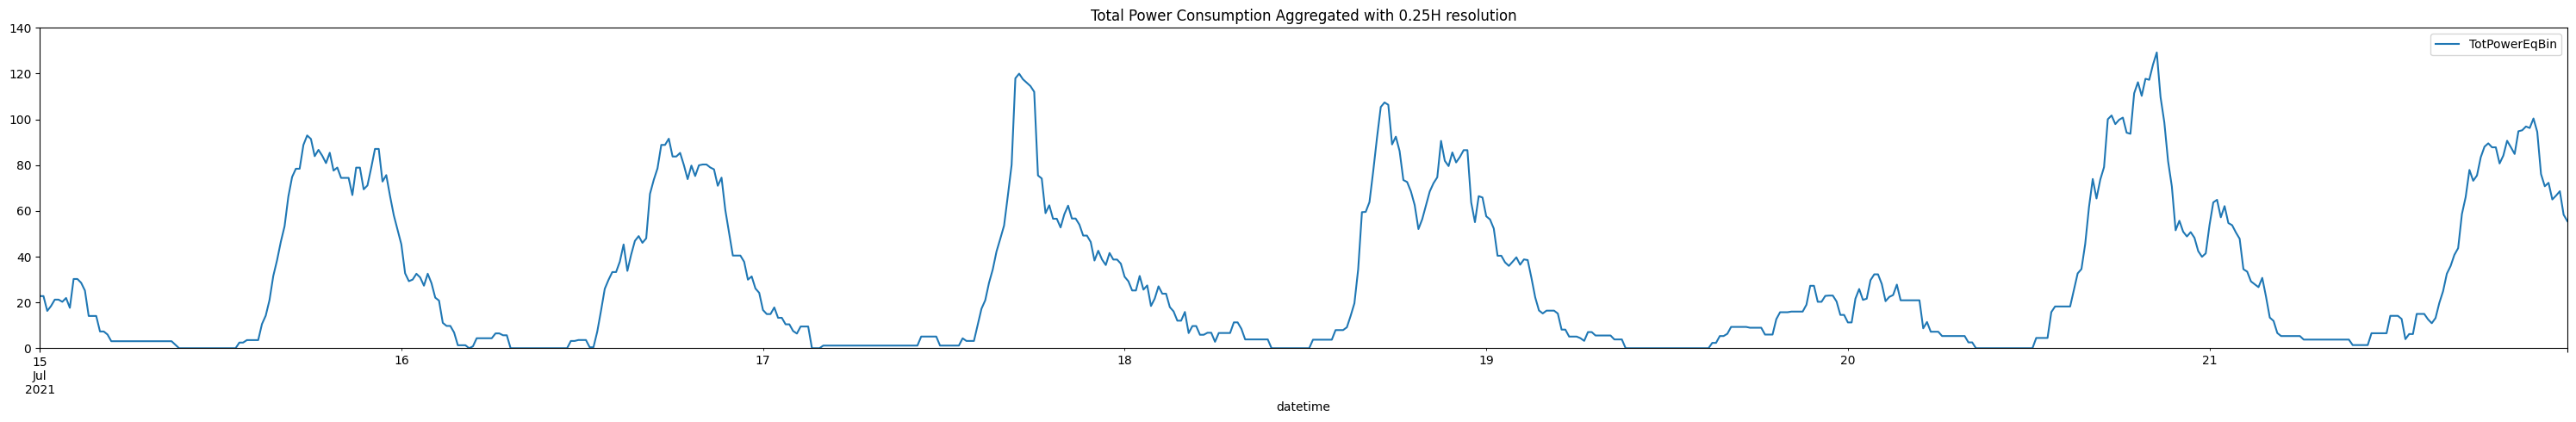

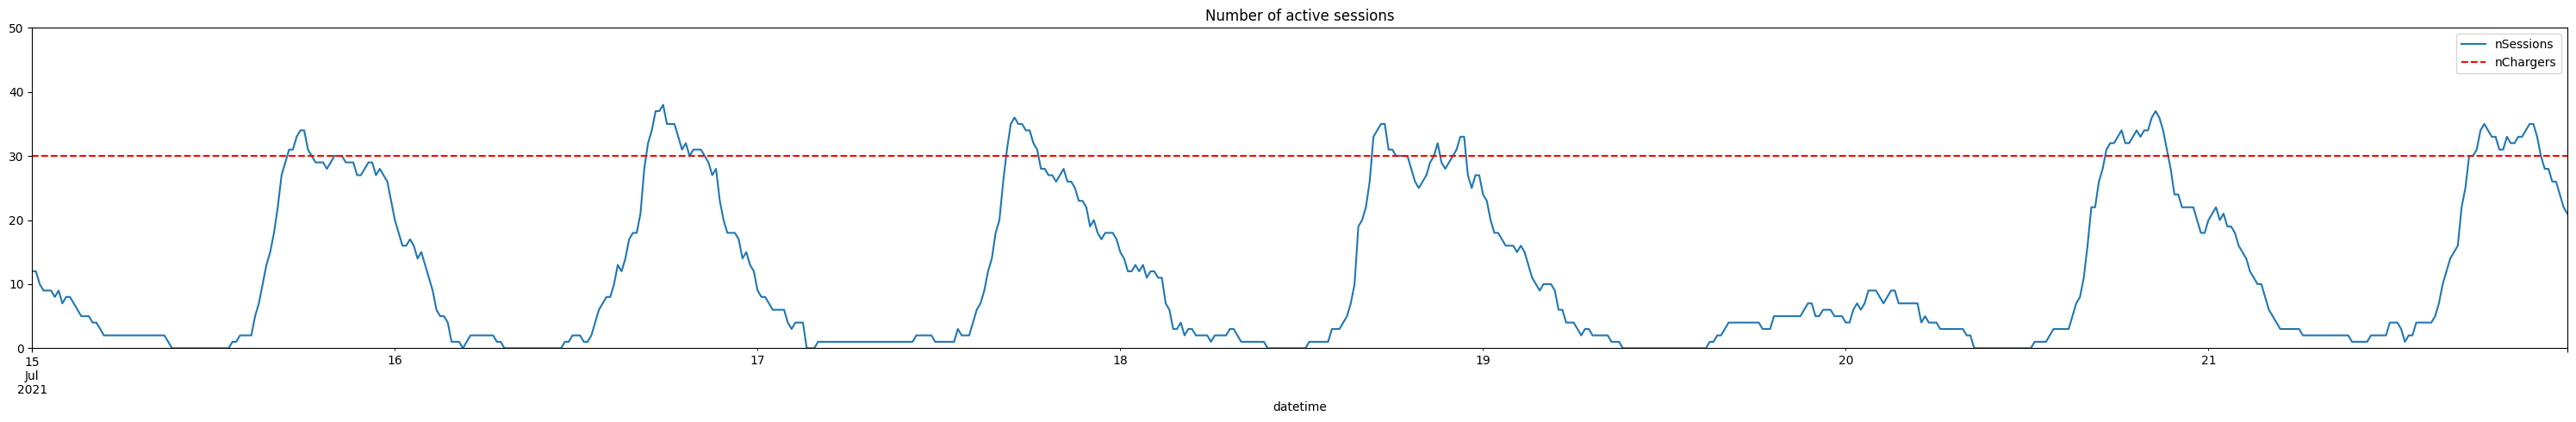

In [32]:
print_ts_agg(df=testAggQHdt, resInHours=0.25, weekIdStart=1, lengthInWeeks=2)
print_ts_agg(df=testNSessionsNowdt, resInHours=0.25, weekIdStart=1, lengthInWeeks=2, nChargers=nChargers)

In [33]:
testEqBinQHcopy = testEqBinQH.copy() 
testEqBinQHcopy, testDelaysSessions, testDelaysAggdt = sim_queuing(nChargers=nChargers, nSessionsToQueuedt=testNSessionsNowdt, 
                                                                   sessionsToQueue=testEqBinQHcopy, resInHours=0.25, verbose=False, 
                                                                   thresholdnChargers=thresholdnChargers)

Simulating queue: 100%|██████████| 169/169 [00:00<00:00, 263.88it/s]


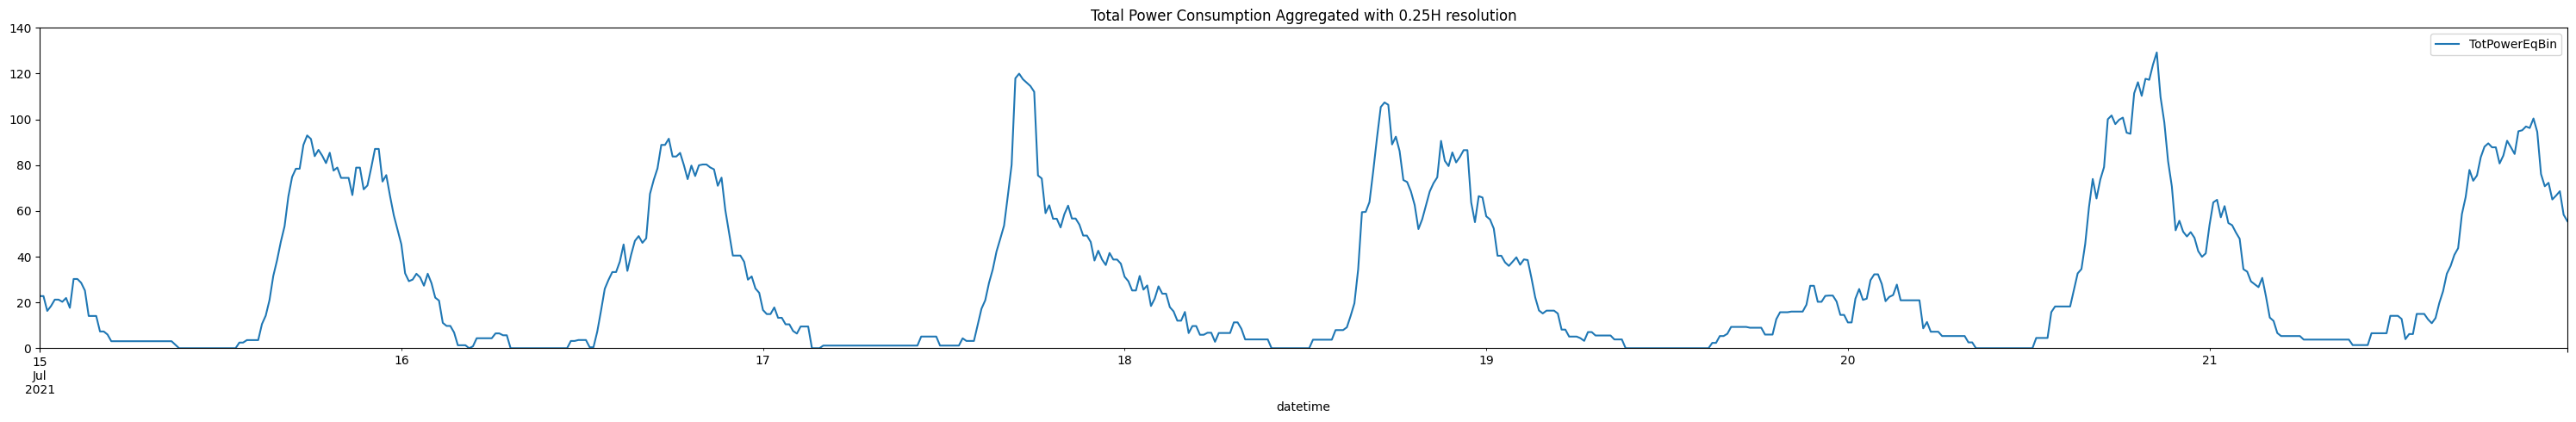

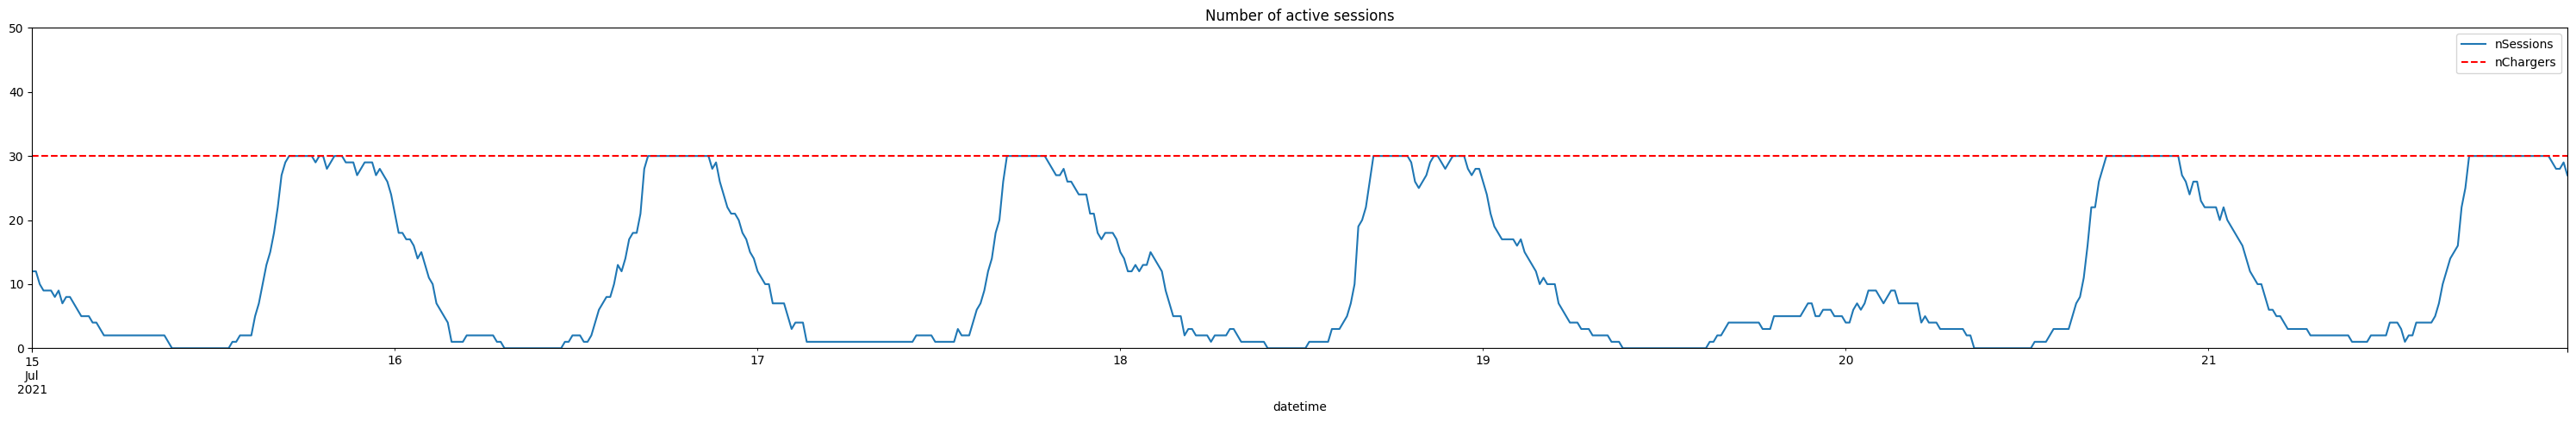

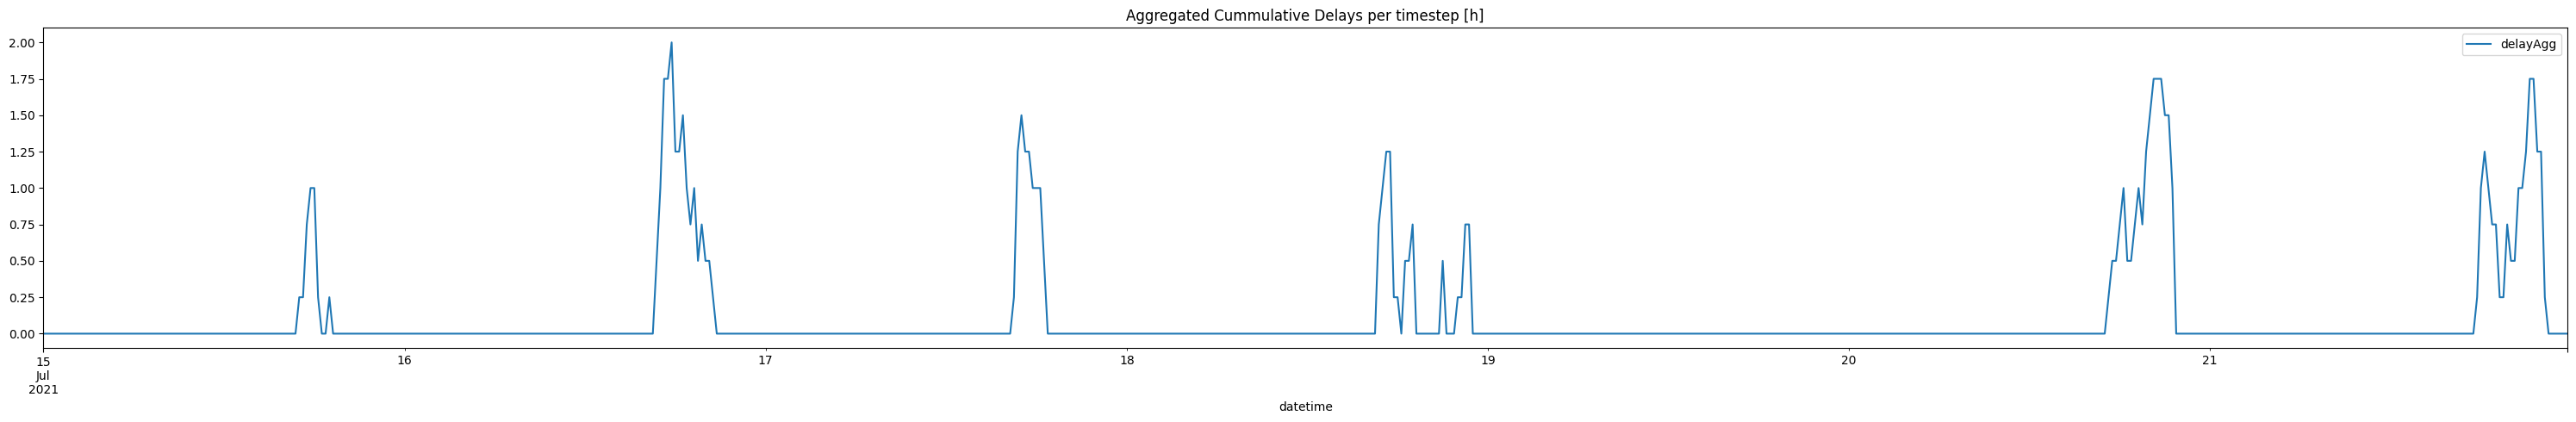

In [34]:
testnSessionsNow = (testEqBinQHcopy != 0).sum(axis=0)
testNSessionsNowdt = pd.DataFrame({'datetime': testNSessionsNowdt['datetime'], 'nSessions': testnSessionsNow})

print_ts_agg(df=testAggQHdt, resInHours=0.25, weekIdStart=1, lengthInWeeks=2)
print_ts_agg(df=testNSessionsNowdt, resInHours=0.25, weekIdStart=1, lengthInWeeks=2, nChargers=nChargers)
testDelaysAggdt.plot(x='datetime', y='delayAgg', figsize=(30, 5), title='Aggregated Cummulative Delays per timestep [h]')
plt.tight_layout()

In [35]:
testEqBinQHBoolOG = (testEqBinQH != 0).astype(float)
testEqBinQHBool = (testEqBinQHcopy != 0).astype(float)
testEqBinQHBoolOG[testDelaysSessions > 0, :] = testEqBinQHBoolOG[testDelaysSessions > 0, :] * 4
testEqBinQHBool[testDelaysSessions > 0, :] = testEqBinQHBool[testDelaysSessions > 0, :] * (4 + testDelaysSessions[testDelaysSessions > 0][:, None])

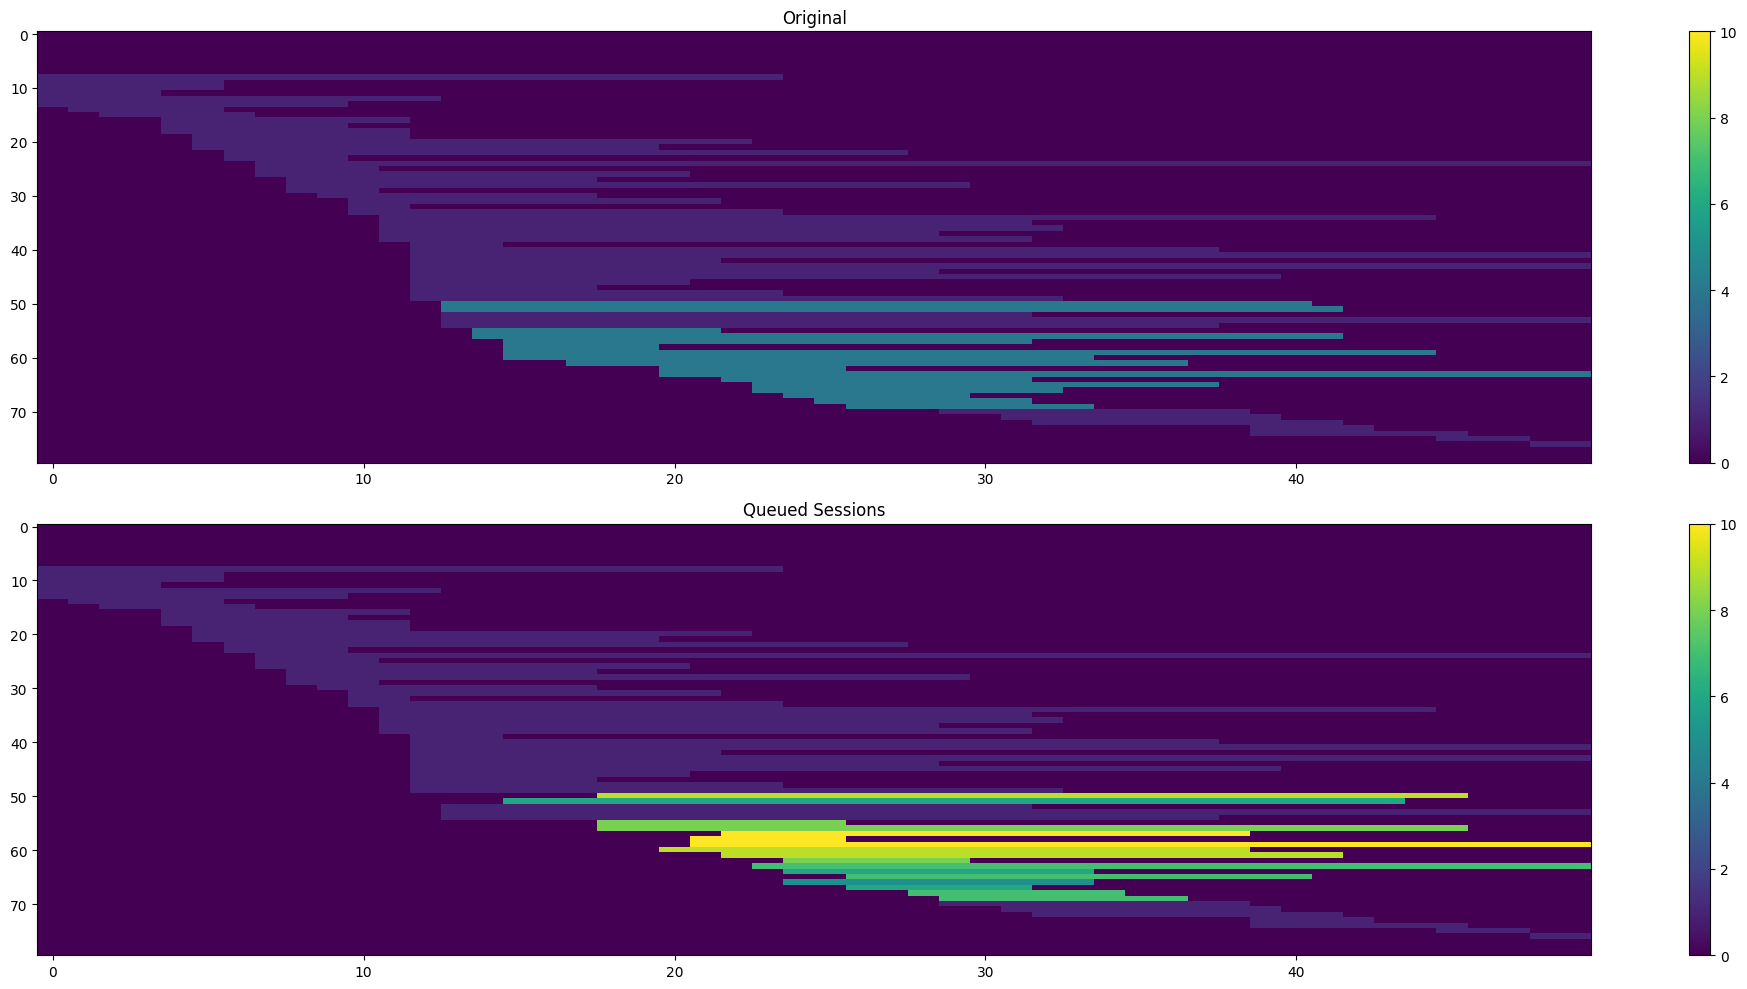

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].imshow(testEqBinQHBoolOG[770:850, 150:200], aspect='auto')
ax[0].set_title('Original')
ax[1].imshow(testEqBinQHBool[770:850, 150:200], aspect='auto')
ax[1].set_title('Queued Sessions')
cb0 = fig.colorbar(ax[0].images[0], ax=ax[0])
cb0.mappable.set_clim(0, 10)
cb1 = fig.colorbar(ax[1].images[0], ax=ax[1])
cb1.mappable.set_clim(0, 10)
plt.tight_layout()

#### All

In [37]:
# queuing all sessions
nSessionsNow = (EqBinQH != 0).sum(axis=0)
nSessionsNowdt = pd.DataFrame({'datetime': AggQHdt['datetime'], 'nSessions': nSessionsNow})
nSessionsNowdtcopy = nSessionsNowdt.copy()
EqBinQH, _, delaysAggdt = sim_queuing(nChargers=nChargers, nSessionsToQueuedt=nSessionsNowdt, sessionsToQueue=EqBinQH, 
                                      resInHours=0.25, verbose=False, thresholdnChargers=thresholdnChargers)

Simulating queue: 100%|██████████| 3342/3342 [21:47<00:00,  2.56it/s]  


In [38]:
print(EqBinQH.shape)
# nSessionsNow = (EqBinQH != 0).sum(axis=0)
# nSessionsNowdt = pd.DataFrame({'datetime': AggQHdt['datetime'], 'nSessions': nSessionsNow})
nNow = (EqBinQH != 0).sum(axis=0)
nNowdt = pd.DataFrame({'datetime': AggQHdt['datetime'], 'nSessions': nNow})
# print_ts_agg(df=nSessionsNowdt, resInHours=0.25, weekIdStart=2, lengthInWeeks=0.3*4, nChargers=nChargers)
# print_ts_agg(df=AggQHdt, resInHours=0.25, weekIdStart=0, lengthInWeeks=4*1)

(11505, 17616)


In [39]:
# print(f"Number of steps over the nChargers: {len(nSessionsNow[nSessionsNow > nChargers])}") # change threshold until there are no more sessions above nChargers
# nSessionsNowdt.loc[nSessionsNowdt['nSessions'] > nChargers, :]
print(f"Number of steps over the nChargers: {len(nNow[nNow > nChargers])}") # change threshold until there are no more sessions above nChargers
nNowdt.loc[nNowdt['nSessions'] > nChargers, :]
#

Number of steps over the nChargers: 0


Empty DataFrame
Columns: [datetime, nSessions]
Index: []

#### Power Re-aggregation

In [40]:
AggNew = EqBinQH.sum(axis=0)
AggNewdt = pd.DataFrame({'datetime': AggQHdt['datetime'], 'TotPowerEqBin': AggNew})

(11505, 17616)


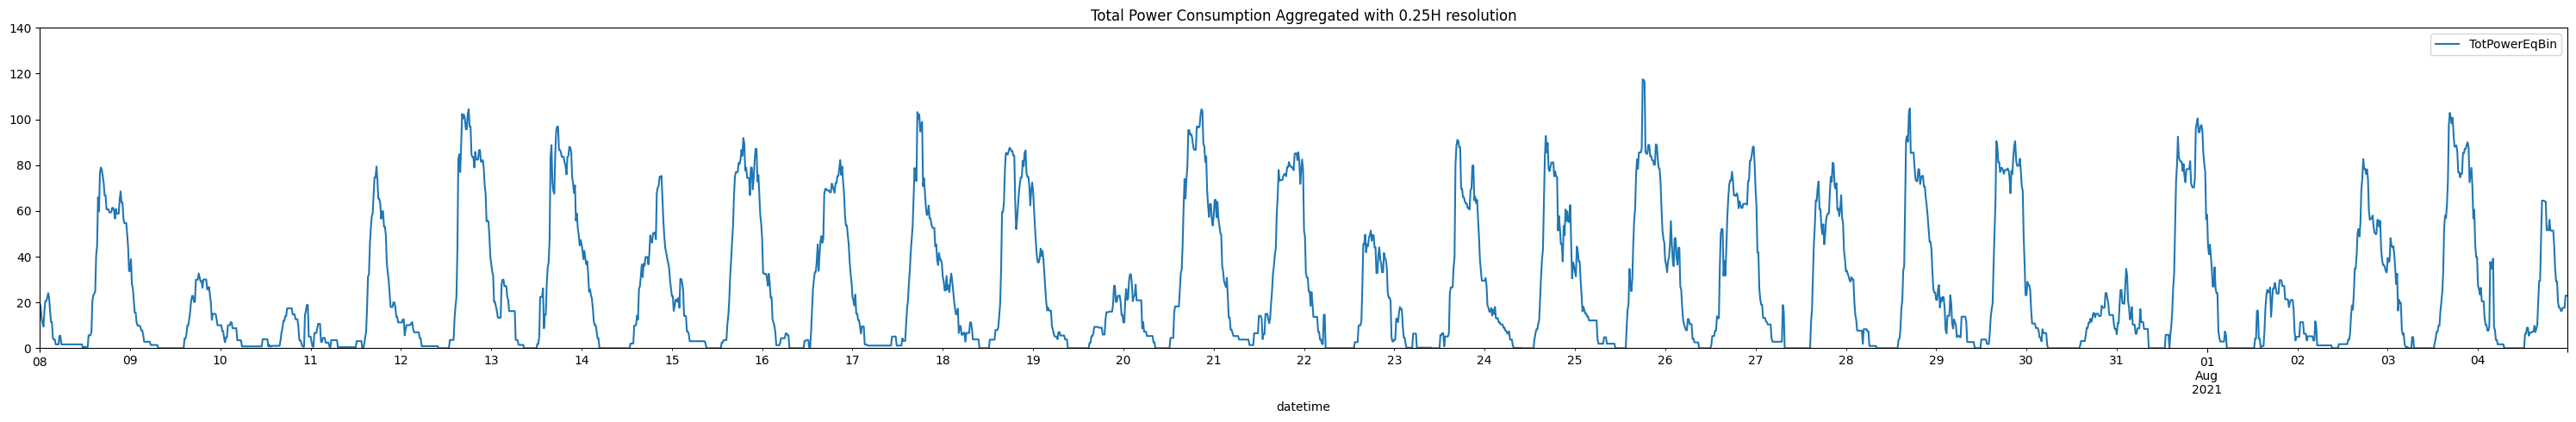

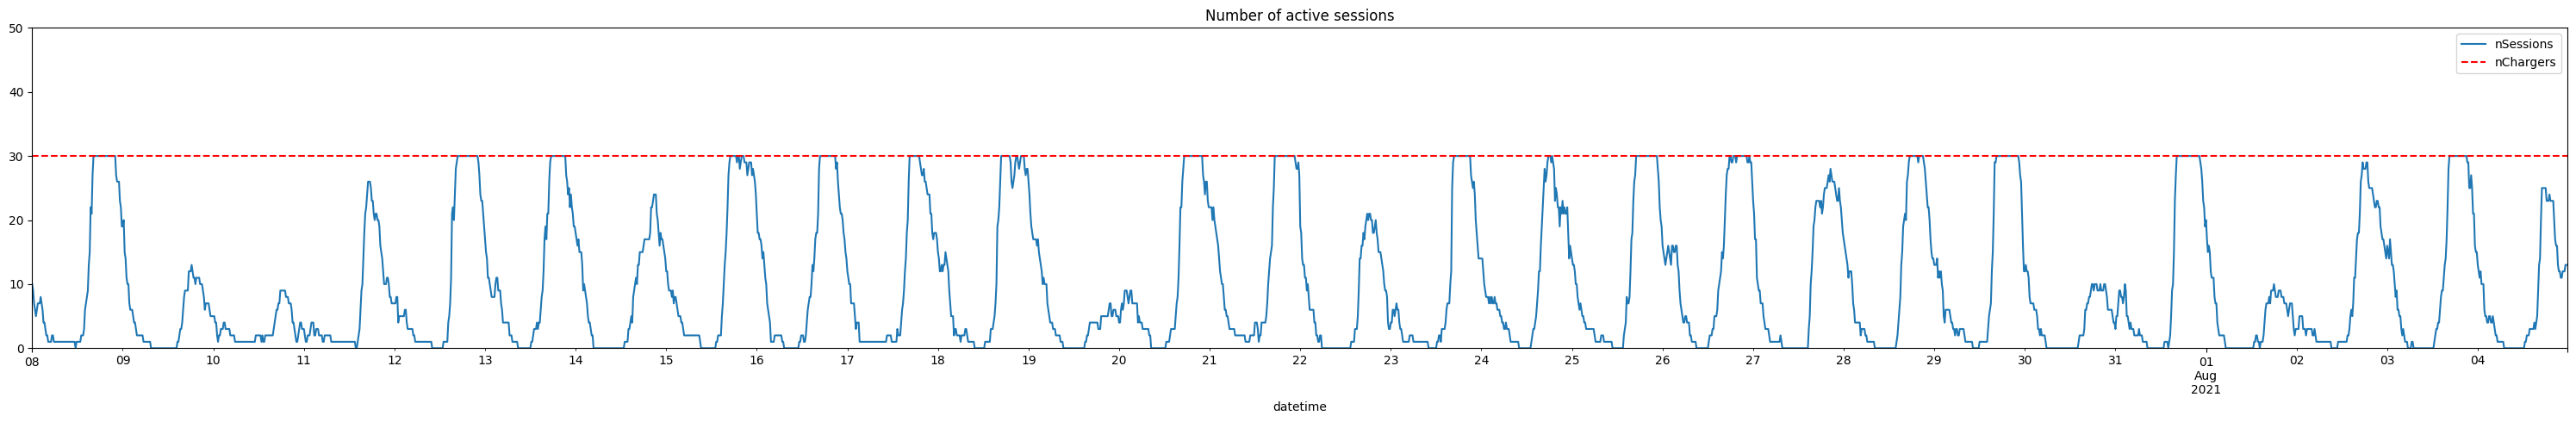

In [41]:
print(EqBinQH.shape)
nSessionsNow = (EqBinQH != 0).sum(axis=0)
nSessionsNowdt = pd.DataFrame({'datetime': AggNewdt['datetime'], 'nSessions': nSessionsNow})
print_ts_agg(df=AggNewdt, resInHours=0.25, weekIdStart=1, lengthInWeeks=4*1)
print_ts_agg(df=nSessionsNowdt, resInHours=0.25, weekIdStart=1, lengthInWeeks=4*1, nChargers=nChargers)


In [43]:
AggNSessionsdt = pd.merge(nSessionsNowdt, AggNewdt, on='datetime', how='inner')
AggNSessionsdt

datetime  nSessions  TotPowerEqBin
0     2021-07-01 00:00:00-07:00          0       0.000000
1     2021-07-01 00:15:00-07:00          1       4.202491
2     2021-07-01 00:30:00-07:00          1       4.202491
3     2021-07-01 00:45:00-07:00          1       4.202491
4     2021-07-01 01:00:00-07:00          1       4.202491
...                         ...        ...            ...
17611 2021-12-31 09:45:00-08:00          0       0.000000
17612 2021-12-31 10:00:00-08:00          0       0.000000
17613 2021-12-31 10:15:00-08:00          0       0.000000
17614 2021-12-31 10:30:00-08:00          0       0.000000
17615 2021-12-31 10:45:00-08:00          0       0.000000

[17616 rows x 3 columns]

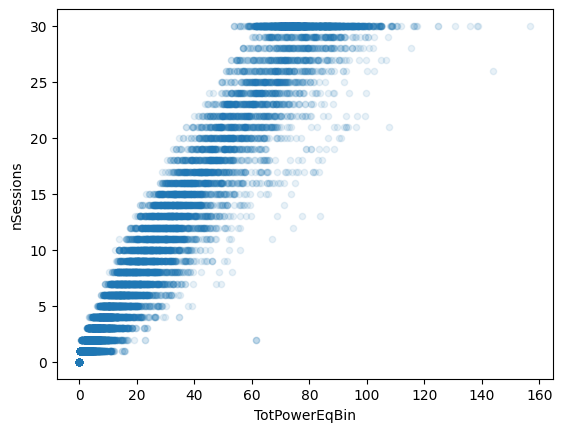

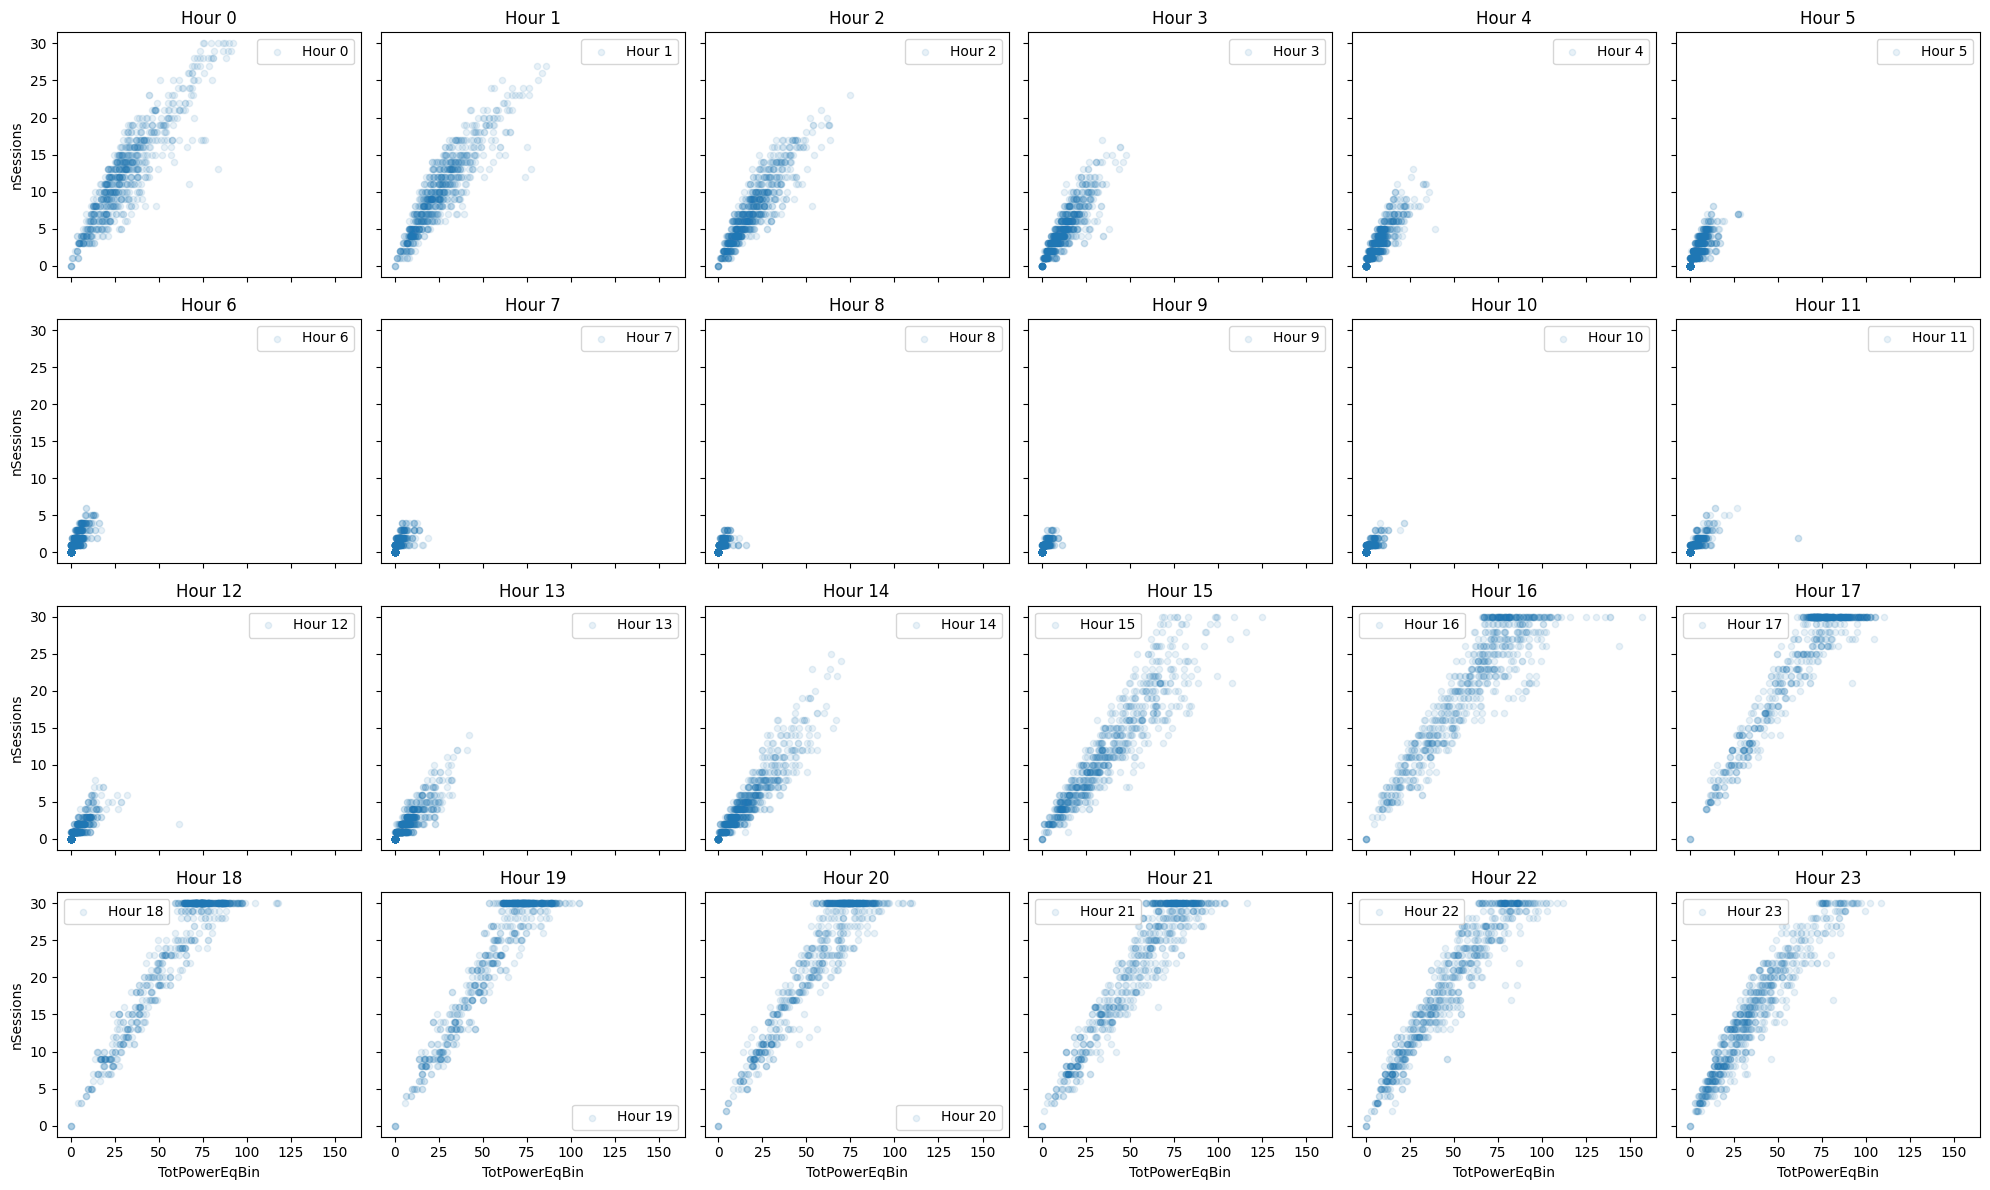

In [44]:
# EcAggNSessionsdt = EcAggNSessionsdt.loc[(EcAggNSessionsdt['datetime'] < pd.to_datetime(dateStart, utc=False).tz_localize('America/Los_Angeles') + pd.Timedelta(weeks=52)), :]            
AggNSessionsdt.plot(x='TotPowerEqBin', y='nSessions', kind='scatter', alpha=0.1)

# plot per hour
AggNSessionsdt['arrivalHour'] = AggNSessionsdt['datetime'].dt.hour
fig, axes = plt.subplots(4, 6, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

for hour, grp in AggNSessionsdt.groupby('arrivalHour'):
    if hour < 24:
        grp.plot(x='TotPowerEqBin', y='nSessions', kind='scatter', alpha=0.1,
                 ax=axes[hour], label=f'Hour {hour}')
        axes[hour].set_title(f'Hour {hour}')
        axes[hour].legend()

plt.tight_layout()

In [45]:
# sm.graphics.tsa.plot_acf(AggNSessionsdt['nSessions'], lags=96)
# sm.graphics.tsa.plot_pacf(AggNSessionsdt['nSessions'], lags=96)
# plt.show()

#### Delays

In [46]:
allDataEVAggdt = pd.merge(AggNSessionsdt, delaysAggdt, on='datetime', how='inner')
allDataEVAggdt.head()

datetime  nSessions  TotPowerEqBin  arrivalHour  delayAgg
0 2021-07-01 00:00:00-07:00          0       0.000000            0       0.0
1 2021-07-01 00:15:00-07:00          1       4.202491            0       0.0
2 2021-07-01 00:30:00-07:00          1       4.202491            0       0.0
3 2021-07-01 00:45:00-07:00          1       4.202491            0       0.0
4 2021-07-01 01:00:00-07:00          1       4.202491            1       0.0

In [47]:
delaysAggdt['arrivalHour'] = delaysAggdt['datetime'].dt.hour

<Axes: xlabel='arrivalHour', ylabel='delayAgg'>

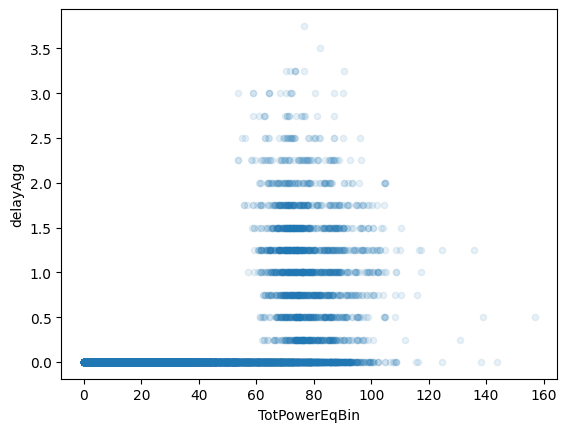

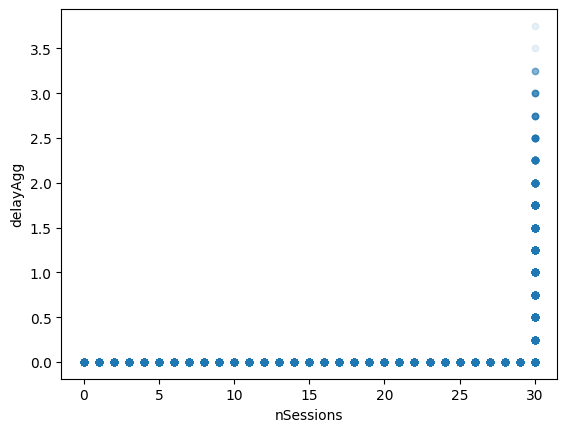

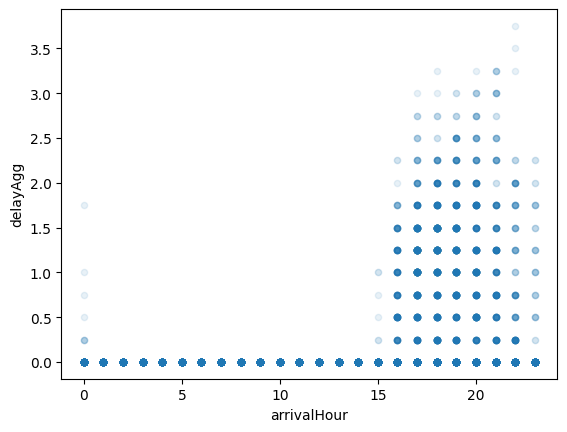

In [48]:
merged = pd.merge(delaysAggdt, AggNewdt, on='datetime', how='inner')
merged2 = pd.merge(delaysAggdt, nSessionsNowdt, on='datetime', how='inner')
merged.plot(x='TotPowerEqBin', y='delayAgg', kind='scatter', alpha=0.1)
merged2.plot(x='nSessions', y='delayAgg', kind='scatter', alpha=0.1)
delaysAggdt.plot(x='arrivalHour', y='delayAgg', kind='scatter', alpha=0.1)

In [49]:
# sm.graphics.tsa.plot_acf(delaysAggdt['delayAgg'], lags=96)
# sm.graphics.tsa.plot_pacf(delaysAggdt['delayAgg'], lags=96)
# plt.show()

In [50]:
delaysAggdt.head(5)

datetime  delayAgg  arrivalHour
0 2021-07-01 00:00:00-07:00       0.0            0
1 2021-07-01 00:15:00-07:00       0.0            0
2 2021-07-01 00:30:00-07:00       0.0            0
3 2021-07-01 00:45:00-07:00       0.0            0
4 2021-07-01 01:00:00-07:00       0.0            1

## Checks and saving

In [52]:
sessionsEV.iloc[:5,:].round(2)

beginDateTime  durationInHours  kWhDelivered
0 2021-07-01 00:15:06.436874937-07:00              1.2          5.25
1 2021-07-01 01:22:29.781324382-07:00              1.0          7.33
2 2021-07-01 12:29:08.253034339-07:00              0.9          5.42
3 2021-07-01 14:22:31.309399754-07:00              2.1         10.86
4 2021-07-01 14:36:10.339807687-07:00              4.0         14.01

In [53]:
allDataEVAggdt.head(10).round(2)

datetime  nSessions  TotPowerEqBin  arrivalHour  delayAgg
0 2021-07-01 00:00:00-07:00          0           0.00            0       0.0
1 2021-07-01 00:15:00-07:00          1           4.20            0       0.0
2 2021-07-01 00:30:00-07:00          1           4.20            0       0.0
3 2021-07-01 00:45:00-07:00          1           4.20            0       0.0
4 2021-07-01 01:00:00-07:00          1           4.20            1       0.0
5 2021-07-01 01:15:00-07:00          2          11.53            1       0.0
6 2021-07-01 01:30:00-07:00          1           7.33            1       0.0
7 2021-07-01 01:45:00-07:00          1           7.33            1       0.0
8 2021-07-01 02:00:00-07:00          1           7.33            2       0.0
9 2021-07-01 02:15:00-07:00          0           0.00            2       0.0

In [54]:
fileName = str(nChargers) + 'MAX_' + str(daysToAggregate) + 'D_' + '0.25H_' + AggQHdt['datetime'].dt.date[0].strftime('%Y-%m-%d') + '_' + AggQHdt['datetime'].dt.date[len(AggQHdt)-1].strftime('%Y-%m-%d')
print(f"Saving aggregated energy demand, cumulative delays and total active sessions to {fileName}")

Saving aggregated energy demand, cumulative delays and total active sessions to 30MAX_182.5D_0.25H_2021-07-01_2021-12-31


In [ ]:
# allDataEVAggdt.drop('arrivalHour', axis=1, inplace=True)
# allDataEVAggdt.to_csv('Data/EV_CA_US/allPower_' + fileName + '.csv')

# # sessionsEV.to_csv('Data/sessionsEV_original.csv')
# # np.save('Data/EcEqBinQH_' + fileName + '.npy', EcEqBinQH) # numpy object is too large. save sessionsEV and use aggregate_EVs to recreate it

In [57]:
# allEVAggread.drop('arrivalHour', axis=1, inplace=True)
# allEVAggread.to_csv('Data/EV_CA_US/allEVAgg_30MAX_182.5D_0.25H_2019-07-01_2020-01-13.csv')